# Learning with MNIST 

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
print(mnist)


{'DESCR': 'mldata.org dataset: mnist-original', 'COL_NAMES': ['label', 'data'], 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.]), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}


In [4]:
def plot_digit(digit):
    import matplotlib
    import matplotlib.pyplot as plt
    digit_image = digit.reshape(28,28)
    plt.imshow(digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

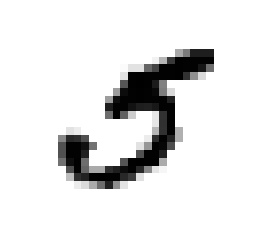

5.0


In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
X, y = mnist["data"], mnist["target"]
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
print(y[36000])

In [6]:
import numpy as np
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binary Classifiers

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
print(sgd_clf.predict([some_digit]))
print(y[36000])

[ True]
5.0


### Implement Cross Validation

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) #Should print .9502, .96565 .96495

0.9653
0.96575
0.96965


##### Alternatively use cross_val_score()

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9653 ,  0.96575,  0.96965])

### Train binary classifier to detect not-5 (always guesses not 5)

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.90955,  0.90965,  0.90975])

### Use confusion matrix to count instances a digit is confused with another

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[54106,   473],
       [ 1513,  3908]])

### Precision and recall

In [13]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.892033782241
0.720900202915


In [14]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7973882881044686

In [15]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 36483.36669247])

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

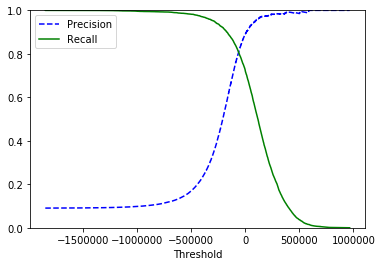

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

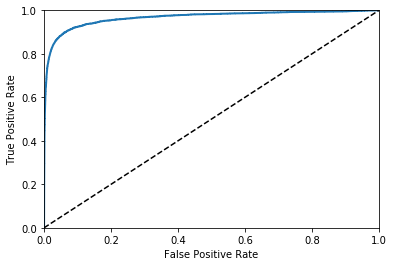

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

#### Precision vs Recall: Inversely related. High precision = low recall = high false negative. Low precision = high recall = high false positive

#### Computer area under curve to compare classifiers (higher = better)

In [19]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96651783343122832

Use PR curve when positive class is rare or care more about false positives than false negatives.

#### Train a random forest classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] #Score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

#### And plot it's ROC Curve

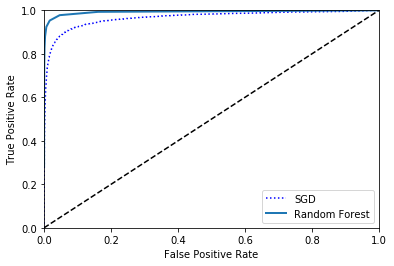

In [21]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [22]:
y_train_forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(roc_auc_score(y_train_5, y_scores_forest))
print(precision_score(y_train_5, y_train_forest_pred))
print(recall_score(y_train_5, y_train_forest_pred))

0.992866137771
0.98398068905
0.827153661686


# Multiclass Classifiers

Choose between one versus all or one versus one. For most algorithms, One vs All is preferred but for mnist we will use one vs one since it is more efficient on small training sets.

In [23]:
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit])) # Reminder: some_digit = X[36000]
print(y[36000])

[ 5.]
5.0


In [24]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -89751.78487197, -498517.01273898, -326349.0710279 ,
        -198074.82243373, -418340.99829775,   36483.36669247,
        -716922.90449642, -254773.44600179, -613566.8366611 ,
        -737266.17513545]])

In [25]:
np.argmax(some_digit_scores)

5

In [26]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [27]:
sgd_clf.classes_[5]

5.0

### To force OvO or OvA, use the respective import and pass in a corresponsding classifier

In [28]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[ 5.]
45


#### Train a random forest classifier. does not need to specify OvO or OvA since a random forest can directly classify multiple classes

In [29]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

#### Look at the forest classifiers probablities of matching different classes

In [30]:
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0. ,  0.1,  0. ,  0.9,  0. ,  0. ,  0. ,  0. ]])

In [31]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.87787443,  0.86229311,  0.85492824])

#### We can improve the accuracy further by scaling the inputs

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91021796,  0.90954548,  0.90873631])

# Error Analysis

### Make predictions with cross_val_predict and examine the confusion matrix

In [33]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5747,    3,   25,    8,   10,   38,   38,   10,   40,    4],
       [   2, 6482,   43,   25,    6,   42,    9,    9,  111,   13],
       [  56,   34, 5348,   92,   87,   24,   74,   59,  168,   16],
       [  48,   40,  137, 5321,    3,  247,   35,   53,  137,  110],
       [  16,   25,   38,    9, 5383,    9,   50,   31,   90,  191],
       [  69,   45,   34,  180,   78, 4602,  105,   29,  172,  107],
       [  36,   24,   44,    3,   46,   94, 5617,    7,   47,    0],
       [  26,   20,   65,   29,   55,   11,    4, 5807,   19,  229],
       [  53,  160,   71,  155,   15,  168,   54,   26, 5011,  138],
       [  43,   29,   29,   84,  163,   35,    2,  224,   88, 5252]])

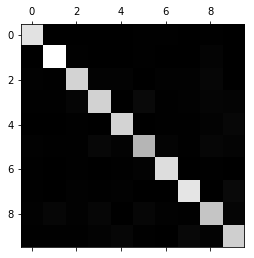

In [34]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

#### Looks like the classifer fails to identify 5s or there aren't many 5s.

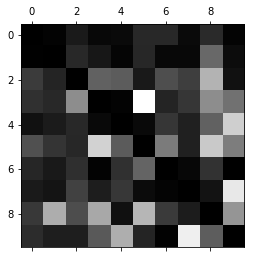

In [35]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Looks like a lot of instances are mislabeled as 8 or 9 by looking at how bright those columns are. 1s and 7s are classified reasonably well.

NameError: name 'plot_digits' is not defined

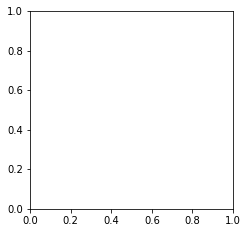

In [101]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Even though the above functions are not defined, one can see that misclassifed samples are sometimes obvious errors. The images should probably be centered and oriented properly before being processed to improve the classification.


# Multilabel classification

In [102]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

# Multioutput Classification

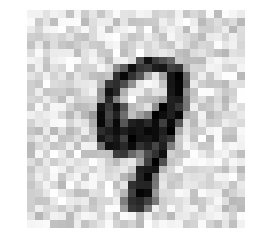

In [39]:
noise_train = np.random.randint(0, 100, (len(X_train), 784 ))
noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise_train
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test
plot_digit(X_train_mod[20000])
plt.show()